# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8810, 9), (4340, 9), (8810,), (4340,))

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

* #### Function Definitios

Using the code created in the Notebook #13, will be define the same functions to create the Decision Tree Classifier Manually and, in that way, calculate the accuracy of the testing set.

In [6]:
# Gini calculator 

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [7]:
# Gini impurity calculator

def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [8]:
# Calculador for the best split given a dataset of feature and target

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
# Decision Tree calculador

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0) # Como guardo la informacion de cada nodo
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
# Decision Tree predictor (given the tree calculated)

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

* #### Calculation

Using the above functions defined, will be create a new *tree* using the training set...

In [11]:
DT_manual = tree_grow(X_train, y_train)
DT_manual

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 98,
    'gain': 0.01707452211653898,
    'sl': {'y_pred': 0,
     'y_prob': 0.04597701149425287,
     'level': 4,
     'split': [1, 37722.0],
     'n_samples': 85,
     'gain': 0.001980228771650633,
     'sl': {'y_pred': 0,
      'y_prob': 0.12,
      'level': 5,
      'split': [1, 33000.0],
      'n_samples': 23,
      'gain': 0.03456656764785304,
      'sl': {'y_pred': 0,
       'y_prob': 0.05555555555555555,
       'level': 6,
       'split': -1,
       'n_sam

Starting from tree created, will predict if a vehicule have a High Price or not using the Test set...

In [12]:
y_pred_m = tree_predict(X_test, DT_manual)
y_pred_m

array([0., 1., 1., ..., 1., 1., 0.])

In [13]:
from sklearn import metrics

print('Accuracy of the model')
print(metrics.accuracy_score(y_test, y_pred_m))

Accuracy of the model
0.8433179723502304


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

Below will be define 10 samples in order to make the bagging of 10 Decision Tree Classifiers using the functions manually defined

In [14]:
np.random.seed(666)

n_samples = X_train.shape[0]
n_B = 10

# will be used to select rows from the DataFrame
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([6380, 7597, 2878, ..., 2275, 8185, 6233]),
 array([4981, 7384, 7525, ...,   32, 7060, 4579]),
 array([3409, 2624,  869, ..., 1651,  806, 3062]),
 array([6719, 2191, 5514, ..., 8319, 3650, 6088]),
 array([6151,  603, 5633, ..., 5484, 8405, 4278]),
 array([4696, 1811, 1278, ...,  170, 3245, 3705]),
 array([ 609, 7131, 8160, ..., 3382,  937, 2686]),
 array([1691, 1340, 2069, ..., 6295, 4421, 1086]),
 array([1296, 8426, 6267, ..., 3546, 5328, 6256]),
 array([3775, 5038, 4341, ..., 2572, 7504, 2675])]

In [15]:
X_train_bag = X_train.iloc[samples[0], :]
X_train_bag.head(5)

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
139708,2015,43676,0,0,0,0,0,1,0
357798,2014,30846,0,0,0,0,1,0,0
424631,2014,11513,0,0,0,0,0,1,0
243344,2014,68988,0,0,0,1,0,0,0
364198,2011,67221,0,1,0,0,0,0,0


From the samples defined, will be calculate each Decision Tree Classifiers

In [16]:
y_pred_tree = []

for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample, :]
    y_train = y_train.iloc[sample]
    tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred_tree.append(tree_predict(X_test, tree))

pd.DataFrame(y_pred_tree) 

,0,1,2,3,4,5,6,7,8,9,...,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
5,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
6,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
7,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
8,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0


Will be defined a Threshold of 50% for the classification.

In [17]:
y_pred = (pd.DataFrame(y_pred_tree).sum() >= (n_B * 0.5 ) ).astype(np.int)

In [18]:

print('Accuracy of the model from a Bagging of 10 Decision Tree Classifiers:')
print(metrics.accuracy_score(y_test, y_pred))

Accuracy of the model from a Bagging of 10 Decision Tree Classifiers:
0.8672811059907835


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

* #### Function Definitios

Will be use as base the function *tree_grow* to define each tree. In this case, will be redefine in order to incorporate the randomness to choose a subdataset from the definition of **max_features** given by the user.

That means, from an main dataset, will be create a new (and smaller) dataset with the amount of features that is provided by the user of the function. 

*Note: The value of max_features cannot be greater than the actual amount of features of the main/original dataset*

In [19]:
# Decision Tree calculador modified

def tree_grow_m(X_, y, max_features=9, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    ########### Max features section ###########
    
    if max_features > (X_.shape[1]):
        return "ERROR: please correct the value 'max_features'"
    
    X = X_
    X_aux = pd.DataFrame(index=X.index) # Empty dataframe
    
    for i in range(max_features): # loop into the number of features defined 
            aux = np.random.choice(a=X.shape[1], replace=True) # Choose randomly de feature to choose
            aux1 = X.iloc[:,(aux - 1)] # Create a single column from the feature defined
            Aux = pd.DataFrame(aux1) # defined as Data Frame
            
            X_aux = pd.concat([X_aux, Aux], axis=1) # Concatenate the empty (or smaller) dataframe, with the new random feature.

    ########### END ###########
            
    # If only one observation
    if X_aux.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0) # Como guardo la informacion de cada nodo
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X_aux, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X_aux.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X_aux.iloc[:, j] < split
    X_l, y_l = X_aux.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X_aux.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

* #### Calculation

Using the above functions defined that include **max_feature**, will be create a new *tree* using the training set...

In [20]:
DT_manual = tree_grow_m(X_train, y_train, max_features=7) # The number "7" can be modified.

In [21]:
y_pred_m = tree_predict(X_test, DT_manual)
y_pred_m

array([1., 1., 1., ..., 1., 1., 1.])

In [22]:
print('Accuracy of the model with max_features')
print(metrics.accuracy_score(y_test, y_pred_m))

Accuracy of the model with max_features
0.597926267281106


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

Will be used the same code as was made in **11.2**, but with the new function defined to calculate the tree with **max_features**

In [23]:
np.random.seed(666)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([6380, 7597, 2878, ..., 2275, 8185, 6233]),
 array([4981, 7384, 7525, ...,   32, 7060, 4579]),
 array([3409, 2624,  869, ..., 1651,  806, 3062]),
 array([6719, 2191, 5514, ..., 8319, 3650, 6088]),
 array([6151,  603, 5633, ..., 5484, 8405, 4278]),
 array([4696, 1811, 1278, ...,  170, 3245, 3705]),
 array([ 609, 7131, 8160, ..., 3382,  937, 2686]),
 array([1691, 1340, 2069, ..., 6295, 4421, 1086]),
 array([1296, 8426, 6267, ..., 3546, 5328, 6256]),
 array([3775, 5038, 4341, ..., 2572, 7504, 2675])]

According to the Exercise statemente, what is "n_features" and "log(n_features)"

In [24]:
n_features = X_train.shape[1] # The amount of the features of the dataset
n_features

9

Since is not clear if should be use the log in base 10 or log in base e, will be use log in base e.

In [25]:
import math
log_nfeatures = math.log(n_features)
log_nfeatures

2.1972245773362196

In [26]:
# same code as before, considering max_features = log(n_features)
y_pred_tree = []

for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample, :]
    y_train = y_train.iloc[sample]
    tree = tree_grow_m(X_train, y_train, max_features=int(np.round(log_nfeatures)),
                       level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred_tree.append(tree_predict(X_test, tree))

pd.DataFrame(y_pred_tree).head()    

,0,1,2,3,4,5,6,7,8,9,...,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [27]:
y_pred = (pd.DataFrame(y_pred_tree).sum() >= (n_B * 0.5 ) ).astype(np.int)

In [28]:
print('Accuracy of the model with max_features from a Bagging of 10 Decision Tree Classifiers')
print(metrics.accuracy_score(y_test, y_pred))

Accuracy of the model with max_features from a Bagging of 10 Decision Tree Classifiers
0.5824884792626728


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

Using `RandomForestClassifier`, will be create a new tree.

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=None, random_state=666, n_jobs=-1)

C:\Users\AMartinez147\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [30]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=666, verbose=0, warm_start=False)

In [31]:
y_pred = clf.predict(X_test)

In [32]:
print('Accuracy of the model - scikit-learn')
print(metrics.accuracy_score(y_test, y_pred))

Accuracy of the model - scikit-learn
0.8467741935483871


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

The methodology to determinate the best `max_depth`, `max_features`, `n_estimators`

* #### max_depth

In [33]:
max_depth_p = []

for Max_depth in range(1, 50):
    clf = RandomForestClassifier(max_depth=Max_depth, random_state=666, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    max_depth_p.append(metrics.accuracy_score(y_test, y_pred))

max_depth_p_df = pd.DataFrame(max_depth_p)
max_depth_p_df.rename(columns={0 : 'max_depth'}, inplace=True)

In [34]:
import matplotlib.pyplot as plt

plt.plot(max_depth_p_df)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Text(0,0.5,'Accuracy')

In [35]:
max_depth_p_df.loc[max_depth_p_df.max_depth == max_depth_p_df["max_depth"].max()]

,max_depth
5,0.868664


* #### max_features

In [36]:
Max_Depth = int(max_depth_p_df.loc[max_depth_p_df.max_depth == max_depth_p_df["max_depth"].max()].index.values)

In [37]:
feature_cols = X.columns[X.columns.str.startswith('C') == False]
max_features_p = []

feature_range = range(1, len(feature_cols)+1)

for Max_features in feature_range:
    clf = RandomForestClassifier(max_depth = (Max_Depth + 1),
                                 max_features = Max_features, random_state=666, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    max_features_p.append(metrics.accuracy_score(y_test, y_pred))
    
max_features_p_df = pd.DataFrame(max_features_p)
max_features_p_df.rename(columns = {0 : 'max_features'}, inplace=True)

Text(0,0.5,'Accuracy')

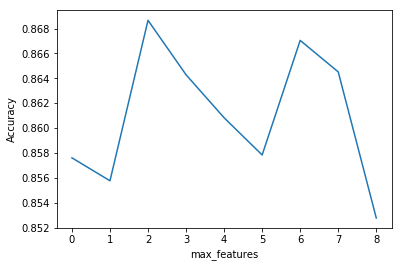

In [38]:
plt.plot(max_features_p_df)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [39]:
max_features_p_df.loc[max_features_p_df.max_features == max_features_p_df["max_features"].max()]

,max_features
2,0.868664


* #### n_estimators

In [40]:
Max_Features = int(max_features_p_df.loc[max_features_p_df.max_features == max_features_p_df["max_features"].max()].index.values)

In [41]:
estimator_range = range(1, 100, 1)
n_estimators_p = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(max_depth = (Max_Depth + 1),
                                 max_features = (Max_Features + 1),
                                 n_estimators=estimator, random_state=666, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    n_estimators_p.append(metrics.accuracy_score(y_test, y_pred))
    
n_estimators_p_df = pd.DataFrame(n_estimators_p)
n_estimators_p_df.rename(columns = {0 : 'n_estimators'}, inplace=True)

Text(0,0.5,'Accuracy')

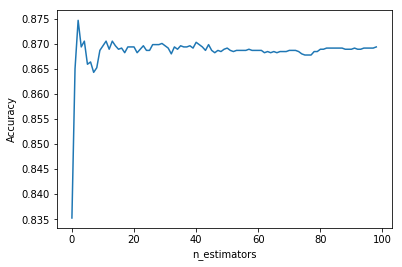

In [42]:
plt.plot(n_estimators_p_df)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [43]:
n_estimators_p_df.loc[n_estimators_p_df.n_estimators == n_estimators_p_df["n_estimators"].max()]

,n_estimators
2,0.874654


Collecting the results, a new Random Forest Classifier will be create!

In [44]:
N_Estimators = int(n_estimators_p_df.loc[n_estimators_p_df.n_estimators == n_estimators_p_df["n_estimators"].max()].index.values)

In [45]:
clf = RandomForestClassifier(max_depth = (Max_Depth + 1),
                             max_features = (Max_Features + 1),
                             n_estimators = (N_Estimators + 1), 
                             random_state=666, n_jobs=-1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [46]:
print('Accuracy of the model - scikit-learn - fitted with the best parameters found.')
print(metrics.accuracy_score(y_test, y_pred))

Accuracy of the model - scikit-learn - fitted with the best parameters found.
0.8746543778801843
